# Tutorial 1 - Generation of impedance data
Now that is clear how to define the input information, we can generate some
data using the `generate_data.py` module.\
First of all, let's add the parent folder path to import the functions that
we need.

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent)) 

## Single element case
### Resistor
To start we can take a single element, for example `R1`, that has an
associated parameter $R = 100\,\Omega$. We have to encode it in a
configuration file, that for this case is the `config_gen_resistor.ini`.\
The encoding is done with the lines

[Circuit]\
diagram = (R1)

[Parameters]\
R1 = 100

NB: The constant elements conditions are not relevant in the generation
module (thus they are all set to 1 from now on).\
In the pyhton module we have to read the configuration file first.

To get the information from the configuration file we have to read it first

In [2]:
import configparser

config = configparser.ConfigParser()
config.read('Configs_tutorial/config_gen_resistor.ini')

['Configs_tutorial/config_gen_resistor.ini']

Then we load the circuit diagram and the parameters inside the config file
into the python module

In [3]:
from generate_data import read_input_circuit_diagram_data, read_input_parameters_data

circuit_diagram = read_input_circuit_diagram_data(config)
parameters = read_input_parameters_data(config)

With that we are creating a `Circuit` object that will contain the
input informaztion

In [4]:
from generate_data import generate_circuit_data

generation_circuit = generate_circuit_data(circuit_diagram, parameters)

From the circuit settings we can get an impedance function, correlated with
its non-constant parameters. A method of the `Circuit` class lets us to
create another object, this time an `AnalysisCircuit` object, that contains
the results of this analysis.

In [5]:
analyzed_circuit = generation_circuit.generate_analyzed_circuit()
impedance_function = analyzed_circuit.impedance

Now we can set the number of frequency points in a specific range: for example
let's take 100 points between $0.1\,Hz$ and $100\,kHz$. In the configuration
file this can be done specifying the lower and upper order of magnitude and
the number of points. The frequencies will have a logarithmic distribution
between the tenth powers of each of the two orders of magnitute

[Frequencies]\
lower_order_of_magnitude = -1\
upper_order_of_magnitude = 5\
number_of_points = 100


In [6]:
from generate_data import read_input_frequencies

frequency = read_input_frequencies(config)

To simulate some random noise we need to extract all the circuit's parameters
first, then the pure signal is generated. The simulated noise is added later

In [7]:
from generate_data import simulate_noise

final_parameters = analyzed_circuit.list_parameters()
impedance_signal = impedance_function(final_parameters, frequency)

For the sake of reproducibility, the seed is set through the configuration
file. The seed chosen for these tutorials is just a number that I liked, with
no other specific reason. Thus in the configuration file

[Noise]
seed = 330

With this we can generate the noise for our signal

In [ ]:
from generate_data import simulate_noise, read_input_seed

seed_number = read_input_seed(config)
impedance = simulate_noise(seed_number, impedance_signal)

Now, if we plot the impedance modulus and phase, we should get a constant
impedance with modulus $Z = 100\,\Omega$ and zero phase.

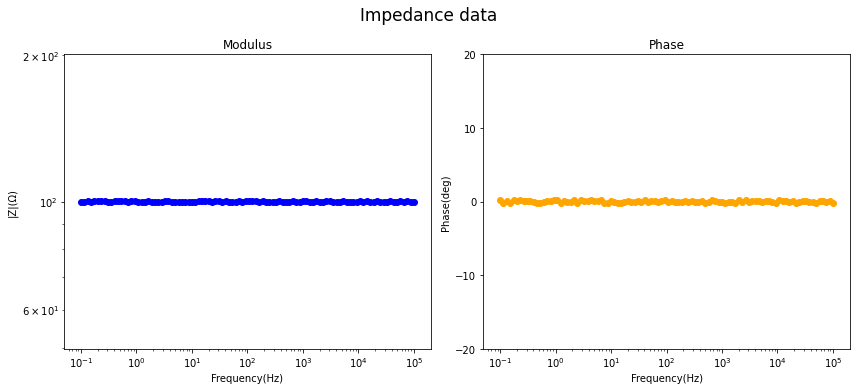

In [9]:
from plot_and_save import plot_data

plot_data(frequency, impedance)

### Capacitor
Another simple example is the capacitor case. We can take a capacitor `C1`
with a capacitance $C = 1\,\mu F$, but let's keep the same frequencies.
Again these settings must be specified in a configuration file

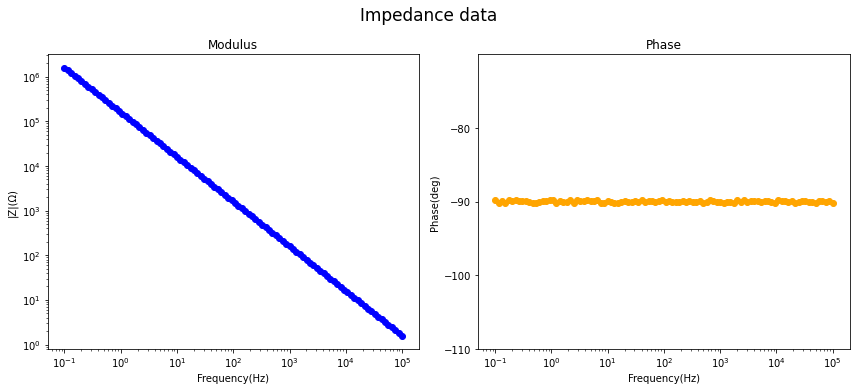

In [10]:
config = configparser.ConfigParser()
config.read('Configs_tutorial/config_gen_capacitor.ini')

circuit_diagram = read_input_circuit_diagram_data(config)
parameters_capacitor = read_input_parameters_data(config)

capacitative_circuit = generate_circuit_data(circuit_diagram,
                                             parameters_capacitor)
analyzed_capacitative_circuit = capacitative_circuit.generate_analyzed_circuit()
impedance_function = analyzed_capacitative_circuit.impedance

final_parameters = analyzed_capacitative_circuit.list_parameters()
impedance_signal = impedance_function(final_parameters, frequency)
seed_number = read_input_seed(config)
impedance = simulate_noise(seed_number, impedance_signal)

plot_data(frequency, impedance)

## Two-element circuit
### RC series 
One of the most basic circuit that however manages to describe real-life data
is the RC series circuit. As explained before, the "in series" junction is
done delimitating the elements with round brakets. The diagram will be then
`(R1C2)` that corresponds to the circuit
<p align="center">
    <img src="Images_tutorial/RC_series.png" alt="image" width="500"/>
</p>

Now, if we set $R = 1\,k\Omega$ and $C = 1\,\mu F$ in the configuration file

[Circuit]\
diagram = (R1C2)

[Parameters]\
R1 = 1000\
C2 = 1e-6


In [11]:
config = configparser.ConfigParser()
config.read('Configs_tutorial/config_gen_RC_series.ini')

circuit_diagram = read_input_circuit_diagram_data(config)
parameters = read_input_parameters_data(config)

circuit_rc = generate_circuit_data(circuit_diagram, parameters)

The resultant plot is

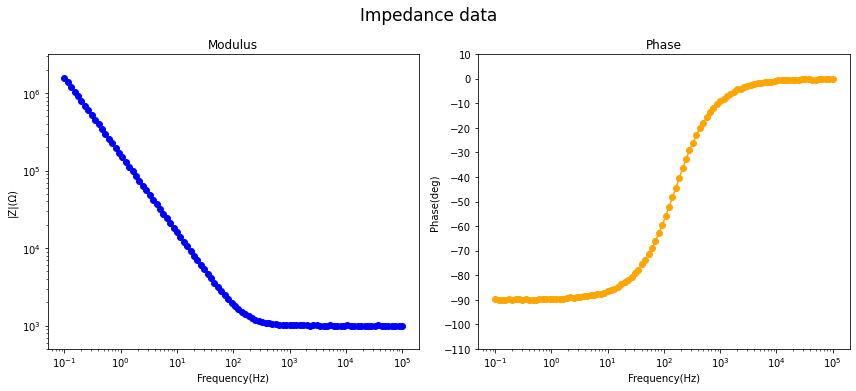

In [12]:
analyzed_circuit_rc = circuit_rc.generate_analyzed_circuit()
impedance_function = analyzed_circuit_rc.impedance

final_parameters = analyzed_circuit_rc.list_parameters()
impedance_signal = impedance_function(parameters, frequency)
seed_number = read_input_seed(config)
impedance = simulate_noise(seed_number, impedance_signal)

plot_data(frequency, impedance)

### RC parallel 
The counterpart of the last circuit is the RC in parallel (below, a scheme).
Now the string must be with the square brackets. If we use the same values
<p align="center">
    <img src="Images_tutorial/RC_parallel.png" alt="image" width="500"/>
</p>

[Circuit]\
diagram = [R1C2]

[Parameters]\
R1 = 1000\
C2 = 1e-6

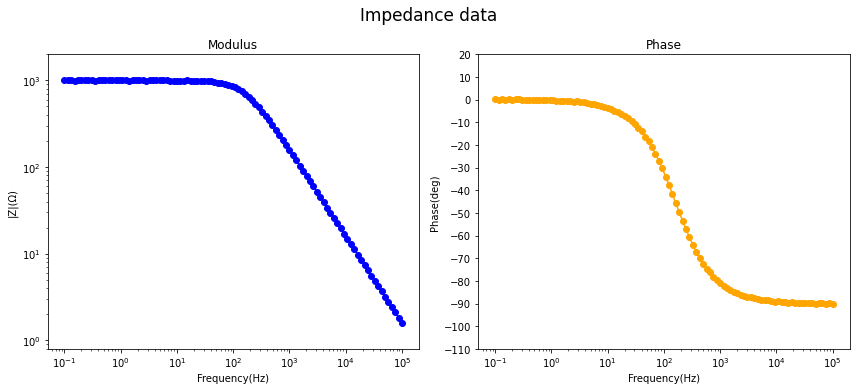

In [13]:
config = configparser.ConfigParser()
config.read('Configs_tutorial/config_gen_RC_parallel.ini')

circuit_diagram = read_input_circuit_diagram_data(config)
parameters = read_input_parameters_data(config)

circuit_rc_p = generate_circuit_data(circuit_diagram, parameters)
analyzed_circuit_rc_p = circuit_rc_p.generate_analyzed_circuit()
impedance_function = analyzed_circuit_rc_p.impedance

final_parameters = analyzed_circuit_rc_p.list_parameters()
impedance_signal = impedance_function(parameters, frequency)
seed_number = read_input_seed(config)
impedance = simulate_noise(seed_number, impedance_signal)

plot_data(frequency, impedance)

### Many elements circuit
To make more complex circuits the only thing to do is write the correct string
and add more parameters. If there are multiple pairs of brackets (which are
not in conflict with each other), called cells, the algorithm will work like
this:
- the elements inside the inner pair of brackets, , (i.e. the most nested
cell) will be analyzed first 
- an equivalent impedance element $Zi$ with its impedance function and
parameters will replace the analyzed elements (and the related brackets)
- the new most nested cell will be analyzed as explained before, and so on
and so fourth until there is only one element $Zi$. This is actually how the
program ran behind the scenes so far.\
Thus, if we take the circuit string `(R1C2[R3Q4])` (that correspond to the
circuit below), during the analysis the string will be transformed as\
`(R1C2[R3Q4])` -> `(R1C2Z1)` -> `Z2`\
At this point, since no bracket is detected, the program knows that the
analysis is done.\
Note: the number after the $Z$ corresponds only to the number of analyzed
cells at the moment the $Zi$ element is created.
<p align="center">
    <img src="Images_tutorial/(R1C2[R3Q4]).png" alt="image" width="460"/>
</p>

For the value of this circuit let's set for the resistors $R1 = 3\,k\Omega$
and $R3 = 10\,k\Omega$ and for the capacitors $C2 = 2\,\mu F$. Regarding the
constant phase elements, we could settle for a $Q = 0.2 \cdot 10^{-6}$ and
an ideality factor $n = 0.82$.

[Circuit]\
diagram = (R1C2[R3Q4])

[Parameters]\
R1 = 3000\
C2 = 2e-6\
R3 = 10000\
Q4 = 0.2e-6 0.82

Note that both $Q$ and $n$ parameters must be put as parameters of the
$Q4$ element of the diagram, with just a whitespace that separates them

In [14]:
config = configparser.ConfigParser()
config.read('Configs_tutorial/config_gen_many_elements.ini')

circuit_diagram = read_input_circuit_diagram_data(config)
parameters = read_input_parameters_data(config)
complex_circuit = generate_circuit_data(circuit_diagram, parameters)

Then, the generated impedance will be

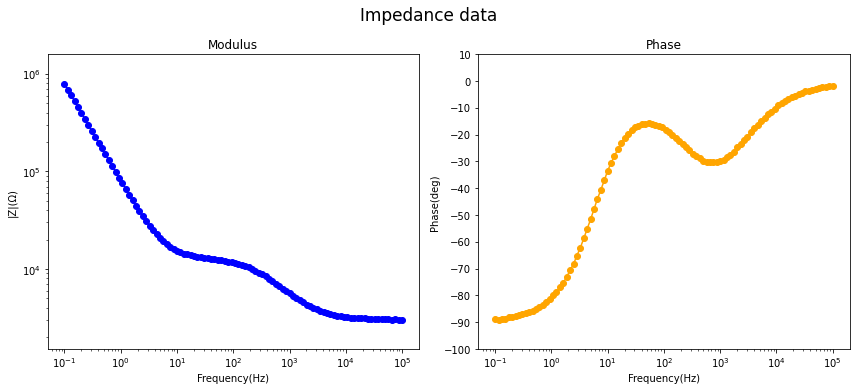

In [15]:
analyzed_complex_circuit = complex_circuit.generate_analyzed_circuit()
impedance_function = analyzed_complex_circuit.impedance

final_parameters = analyzed_complex_circuit.list_parameters()
impedance_signal = impedance_function(parameters, frequency)
seed_number = read_input_seed(config)
impedance = simulate_noise(seed_number, impedance_signal)

plot_data(frequency, impedance)

## Saving the data
After all of this data generation, we may want to save the generated data.
The displayed method is to write the frequency array and the complex
impedance array inside of a `.txt` file, where the two columns are separated  by a
`;`. It is done with

In [16]:
from generate_data import read_output_file_name, read_output_file_format
from plot_and_save import save_data

fine_name = read_output_file_name(config)
number_of_columns = read_output_file_format(config)
save_data(fine_name, number_of_columns, frequency, impedance)

However, the modulus and phase vs frequency format is also avaible, and can be
chosen setting the format equal to `3` in the `File` section of the
configuration file.